### Initialization

In [121]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from xgboost.sklearn import XGBRegressor
pd.options.mode.chained_assignment = None

D:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
D:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
np.random.seed = 1024
random_seed = 1024

In [3]:
data_dir = "../data/"
fig_dir = "../figures/"

### Loading data

In [4]:
train_1 = pd.read_csv(data_dir + "primary_training_part1.csv")
train_2 = pd.read_csv(data_dir + "primary_training_part2.csv")
train_3 = pd.read_csv(data_dir + "primary_training_part3.csv")

In [5]:
train_data = pd.concat([train_1, train_2, train_3]).set_index("PTID")

In [6]:
train_data.head(3)

,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev
PTID,,,,,,
1,1,47,8911,0.0,0,0
2,1,47,46743,0.5,0,0
3,1,70,40287,0.5,0,0


### Preprocessing

In [10]:
def average_wins(df, w_id_col="WhitePlayer", b_id_col="BlackPlayer", result_col="WhiteScore"):
    
    allgames = {}
    for white_id, black_id, result in tqdm(df[[w_id_col, b_id_col, result_col]].values):
        if (white_id, black_id) in allgames:
            allgames[(white_id, black_id)].append(result)
            allgames[(black_id, white_id)].append(1 - result)
        else:
            allgames[(white_id, black_id)] = [result]
            allgames[(black_id, white_id)] = [1 - result]
    
    df[result_col] = [np.mean(allgames[(w_id, b_id)]) for w_id, b_id in df[[w_id_col, b_id_col]].values]
    return df

In [8]:
train_data["YearID"] = (train_data.MonthID - 1) // 12
train_data = train_data.groupby("YearID").apply(average_wins)

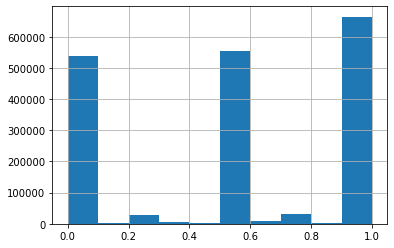

In [11]:
train_data.WhiteScore.hist()

In [12]:
train_data.to_csv(data_dir + "processed.csv")

### Constructing baseline model

In [13]:
def get_loss(df, 
             w_id_col="WhitePlayer", 
             b_id_col="BlackPlayer", 
             feature_cols=[], 
             result_col="WhiteScore", 
             model_func=LinearRegression, 
             feature_dict={}, 
             graph=None, 
             verbose=True, 
             n_jobs=-1, 
             cv=3):
    
    """
    Takes a dataframe and four sets of columns, also a model generating function.
    Provides best loss given by this model.
    """
    
#     if graph is None:
#         allgames = {}
#         for white_id, black_id, result in df[[w_id_col, b_id_col, result_col]].values:
#             if (white_id, black_id) in allgames:
#                 allgames[(white_id, black_id)].append(result)
#                 allgames[(black_id, white_id)].append(1 - result)
#             else:
#                 allgames[(white_id, black_id)] = [result]
#                 allgames[(black_id, white_id)] = [1 - result]

#         for key in allgames:
#             allgames[key] = np.mean(allgames[key]) 
#         y = [allgames[(w_id, b_id)] for w_id, b_id in df[[w_id_col, b_id_col]].values]
#     else:
#         y = [np.mean(graph.nodes[w_id].opponents[b_id]) for w_id, b_id in df[[w_id_col, b_id_col]].values]
    X = df[feature_cols]
    y = df[result_col]
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.9)
    
    model = model_func()
    clf = GridSearchCV(model, feature_dict, cv=cv, verbose=verbose, n_jobs=n_jobs)
    clf.fit(train_X, train_y)
    
    return clf, test_X, train_y, test_y

In [14]:
init_ratings = pd.read_csv(data_dir + "initial_ratings.csv")

In [15]:
init_ratings.head()

,Player,Rating,KFactor,NumGames
0,3,2116,15,30
1,10,2421,10,30
2,16,2252,15,30
3,19,2352,25,10
4,22,2263,15,30


In [16]:
rated = init_ratings.Player.values

In [17]:
rating_dict = {player:rating for player, rating in init_ratings[['Player', 'Rating']].values}

In [18]:
# Using the first three years to test accuracy of FIDE scores
rated_games = train_data.query("(WhitePlayer in @rated) and (BlackPlayer in @rated) and (YearID < 3)")

In [19]:
rated_games.loc[:, "WhiteRating"] = [rating_dict[i] for i in rated_games["WhitePlayer"]]
rated_games.loc[:, "BlackRating"] = [rating_dict[i] for i in rated_games["BlackPlayer"]]

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
rated_games.head()

,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,YearID,WhiteRating,BlackRating
PTID,,,,,,,,,
1,1,47,8911,0.0,0,0,0,2099,2432
2,1,47,46743,0.5,0,0,0,2099,2251
3,1,70,40287,0.5,0,0,0,2017,2317
4,1,90,8188,1.0,0,0,0,2282,2145
5,1,90,31200,0.0,0,0,0,2282,2136


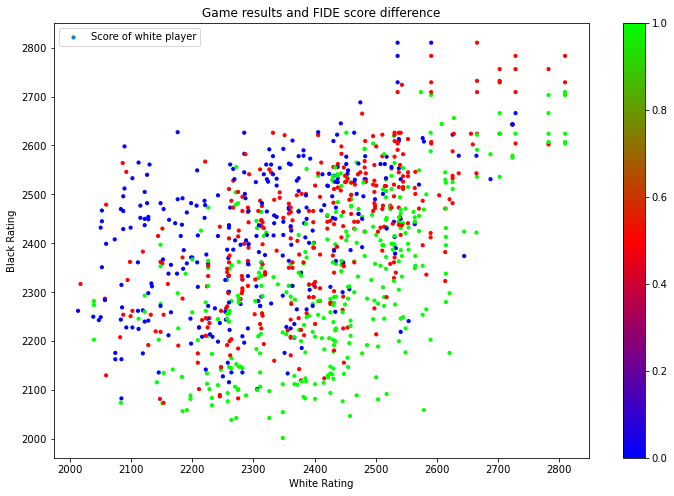

In [50]:
fig = plt.figure(figsize=(12, 8))
sample_games = rated_games.iloc[:1000, :]
plt.scatter(sample_games.WhiteRating, sample_games.BlackRating, s=10, c=sample_games.WhiteScore, label="Score of white player", cmap="brg")
plt.colorbar()
plt.xlabel("White Rating")
plt.ylabel("Black Rating")
plt.legend(loc="upper left")
plt.title("Game results and FIDE score difference")
plt.savefig(fig_dir + "FIDE Results.png")

In [396]:
clf, test_X, train_y, test_y = get_loss(
    rated_games, 
    "WhitePlayer", 
    "BlackPlayer", 
    feature_cols=["WhiteRating", "BlackRating"], 
    result_col="WhiteScore", 
    model_func=LinearRegression
#     feature_dict={"penalty": ["elastic-net"], "l1_ratio": [0.3, 0.5, 0.7]}, 
#     graph=G
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


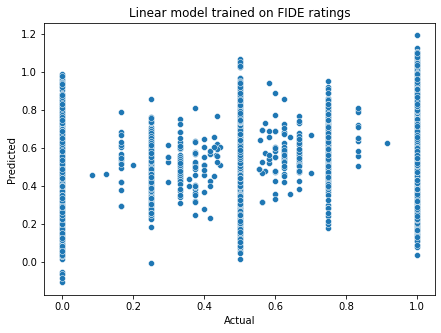

In [397]:
plt.figure(figsize=(7, 5))
fig = sns.scatterplot(x=test_y, y=clf.predict(test_X))
fig.set(xlabel="Actual", ylabel="Predicted")
fig.set_title("Linear model trained on FIDE ratings")
plt.savefig(fig_dir + "baseline_linear.png")

In [409]:
clf, test_X, train_y, test_y = get_loss(
    rated_games, 
    "WhitePlayer", 
    "BlackPlayer", 
    feature_cols=["WhiteRating", "BlackRating"], 
    result_col="WhiteScore", 
    model_func=ElasticNet,
    feature_dict={"l1_ratio": [0.3, 0.5, 0.7], "alpha": [0.1, 1, 10]}
#     graph=G
)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


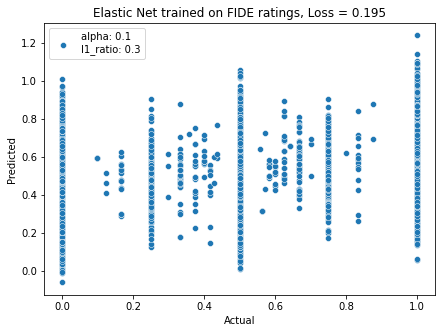

In [414]:
plt.figure(figsize=(7, 5))
fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
fig.set(xlabel="Actual", ylabel="Predicted")
fig.set_title("Elastic Net trained on FIDE ratings, Loss = {:.3f}".format(clf.best_score_))
plt.savefig(fig_dir + "baseline_elasticnet.png")

In [122]:
clf, test_X, train_y, test_y = get_loss(
    rated_games, 
    "WhitePlayer", 
    "BlackPlayer", 
    feature_cols=["WhiteRating", "BlackRating"], 
    result_col="WhiteScore", 
    model_func=XGBRegressor,
    feature_dict={"max_depth": [4, 5, 6], "n_estimators": [30, 100]},
#     graph=G
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    6.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.4s finished


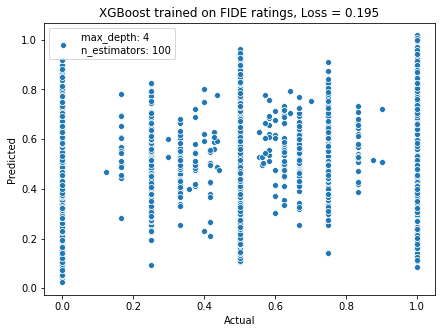

In [123]:
plt.figure(figsize=(7, 5))
fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
fig.set(xlabel="Actual", ylabel="Predicted")
fig.set_title("XGBoost trained on FIDE ratings, Loss = {:.3f}".format(clf.best_score_))
plt.savefig(fig_dir + "baseline_xgb.png")

In [106]:
clf, test_X, train_y, test_y = get_loss(
    rated_games, 
    "WhitePlayer", 
    "BlackPlayer", 
    feature_cols=["WhiteRating", "BlackRating"], 
    result_col="WhiteScore", 
    model_func=RandomForestRegressor,
    feature_dict={"max_depth": [4, 5, 6], "n_estimators": [30, 100]},
#     graph=G
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.8s finished


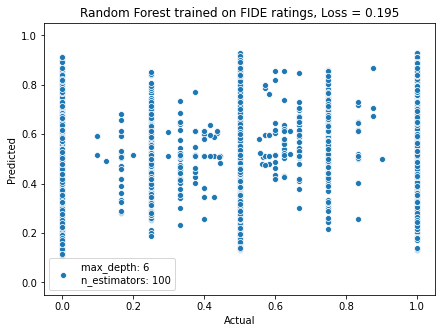

In [107]:
plt.figure(figsize=(7, 5))
fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
fig.set(xlabel="Actual", ylabel="Predicted")
fig.set_title("Random Forest trained on FIDE ratings, Loss = {:.3f}".format(clf.best_score_))
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.savefig(fig_dir + "baseline_randomforest.png")

In [80]:
def plotacc(df, w_sc_col="WhiteScore", b_sc_col="BlackScore", w_r_col="WhiteRating", b_r_col="BlackRating", title="", save_as="temp.png"):

    datasss = []
    for i in [0.0, 0.5, 1.0]:
        datasss.append((df[df[w_sc_col] == i][w_r_col] - df[df[w_sc_col] == i][b_r_col]).values)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.violinplot(datasss, vert=False)
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['White Lost', 'Draw', 'White Won'])
    ax.set_xlabel("Rating Difference")
    ax.set_title(title)
    plt.savefig(fig_dir + save_as)

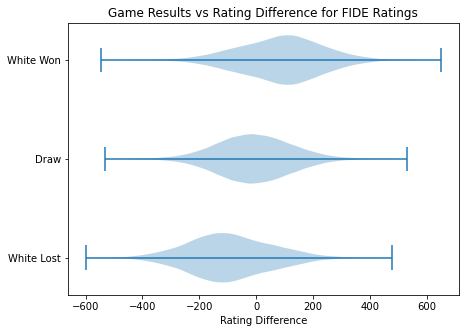

In [426]:
plotacc(rated_games, "WhiteScore", "BlackScore", "WhiteRating", "BlackRating", title="Game Results vs Rating Difference for FIDE Ratings", save_as="baseline_violin.png")

## Scrap Code Begin

We would like to use logistic regression to generate an optimal model for the FIDE scores. We do this in two ways, by treating the features as three non-ordinal outputs or as three ordinal ones.

In [18]:
non_ord_logistic = LogisticRegression()

In [40]:
rated_games['WhiteResult'] = rated_games['WhiteScore'].map({
    0.0: 'Lose',
    0.5: 'Draw',
    1.0: 'Win'
})

D:\Anaconda3\envs\data1030\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [60]:
(train_features, 
 test_features, 
 train_labels, 
 test_labels) = train_test_split(rated_games[['WhiteRating', 'BlackRating']], rated_games.WhiteResult, test_size=0.2, random_state=random_seed, shuffle=True)

In [62]:
non_ord_logistic.fit(train_features, train_labels)

LogisticRegression()

In [69]:
print(np.mean(non_ord_logistic.predict(test_features) == test_labels))
confusion_matrix(non_ord_logistic.predict(test_features), test_labels, labels=['Lose', 'Draw', 'Win'])

0.49617716846823096

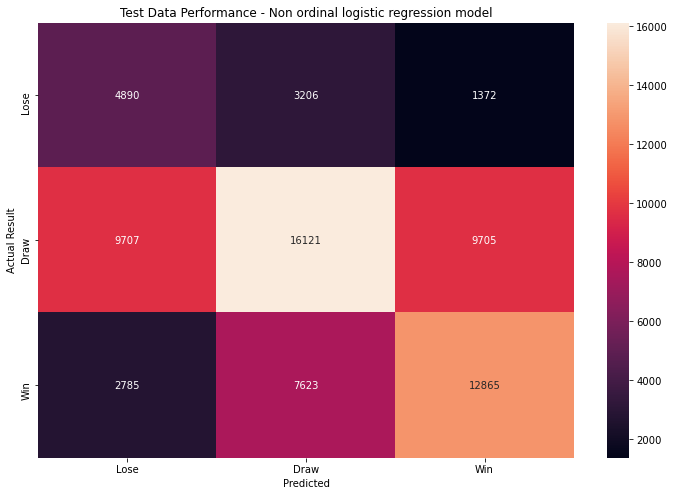

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
p = sns.heatmap(confusion_matrix(non_ord_logistic.predict(test_features), test_labels, labels=['Lose', 'Draw', 'Win']), 
                annot=True, 
                fmt='d')
p.set_xticklabels(["Lose", 'Draw', 'Win'])
p.set_yticklabels(["Lose", 'Draw', 'Win'])
p.set_xlabel('Predicted')
p.set_ylabel('Actual Result')
p.set_title("Test Data Performance - Non ordinal logistic regression model")
plt.savefig(fig_dir + "Test Data Performance - Non ordinal logistic regression model.png")

In [26]:
rated_games['WhiteWon'] = rated_games['WhiteScore'].map({
    0.0: 'No',
    0.5: 'No',
    1.0: 'Yes'
})
rated_games['BlackWon'] = rated_games['WhiteScore'].map({
    0.0: 'Yes',
    0.5: 'No',
    1.0: 'No'
})

D:\Anaconda3\envs\data1030\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda3\envs\data1030\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [75]:
(train_features, 
 test_features, 
 train_white_labels, 
 test_white_labels,
 train_black_labels,
 test_black_labels) = train_test_split(rated_games[['WhiteRating', 'BlackRating']], 
                                       rated_games.WhiteWon, 
                                       rated_games.BlackWon,
                                       test_size=0.2, random_state=random_seed, shuffle=True)

In [27]:
black_logistic = LogisticRegression()
white_logistic = LogisticRegression()

In [76]:
black_logistic.fit(train_features, train_black_labels)
white_logistic.fit(train_features, train_white_labels)

LogisticRegression()

In [78]:
print(np.mean(black_logistic.predict(test_features) == test_black_labels))
confusion_matrix(black_logistic.predict(test_features), test_black_labels, labels=['No', 'Yes'])

0.752965989981545


array([[48960, 14934],
       [ 1932,  2448]], dtype=int64)

In [79]:
print(np.mean(white_logistic.predict(test_features) == test_white_labels))
confusion_matrix(white_logistic.predict(test_features), test_white_labels, labels=['No', 'Yes'])

0.6940123619533058


array([[39523, 16082],
       [ 4809,  7860]], dtype=int64)

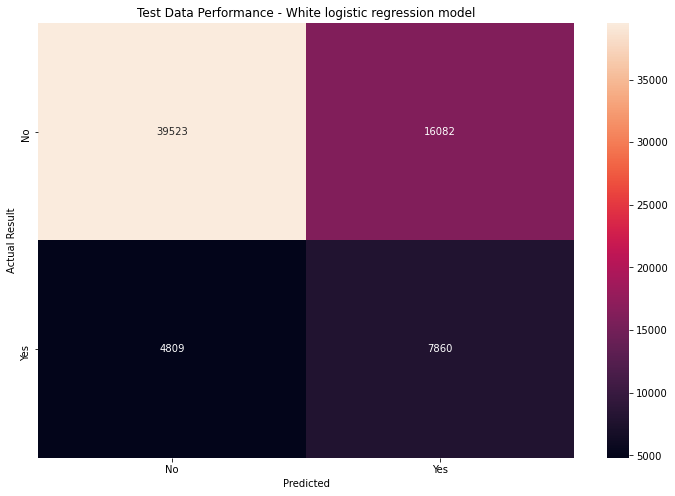

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))
p = sns.heatmap(confusion_matrix(white_logistic.predict(test_features), test_white_labels, labels=['No', 'Yes']), 
                annot=True, 
                fmt='d')
p.set_xticklabels(['No', 'Yes'])
p.set_yticklabels(['No', 'Yes'])
p.set_xlabel('Predicted')
p.set_ylabel('Actual Result')
p.set_title("Test Data Performance - White logistic regression model")
plt.savefig(fig_dir + "Test Data Performance - White logistic regression model.png")

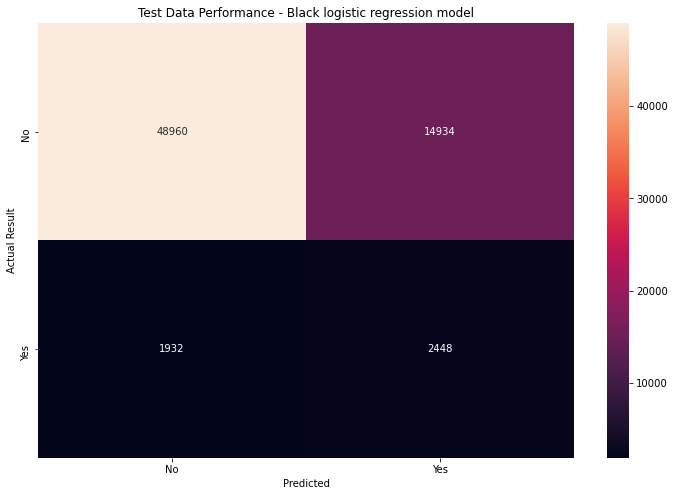

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))
p = sns.heatmap(confusion_matrix(black_logistic.predict(test_features), test_black_labels, labels=['No', 'Yes']), 
                annot=True, 
                fmt='d')
p.set_xticklabels(['No', 'Yes'])
p.set_yticklabels(['No', 'Yes'])
p.set_xlabel('Predicted')
p.set_ylabel('Actual Result')
p.set_title("Test Data Performance - Black logistic regression model")
plt.savefig(fig_dir + "Test Data Performance - Black logistic regression model.png")

## Scrap Code End

## New Model

In [21]:
def truncate(value, low, high):
    
    if value < low:
        return low
    elif value > high:
        return high
    else:
        return value

def score_shift(score_a, score_b, results):
    """
    Returns number of points A loses(wins) to(from) B, e.g. +1 if A should give one point to B
    :param Results: List of {1, 0.5, 0}, with 1 denoting A won a game
    """
    return (truncate((score_a - score_b) / 2, -100, 100) - 200 * (np.mean(results) - 0.5)) * min(1, len(results) / 100)

class ScoreNode():
    """
    Defines every node in graph
    Contains the player id :int,
    Opponents this player has played :Dict(id: mean_of_results)
    """
    def __init__(self, ID, opponents={}, init_rating=1000):
        
        self.id = ID
        self.opponents = opponents
        self.rating = init_rating

class ScoreGraph():
    
    """
    Graph of players being nodes
    """
    
    def __init__(self, df, result_col, white_col, black_col, init_rating=1000):
        """
        Initializes graph
        """
        self.nodes = {}
        edges = {}
        for game in df[[white_col, black_col, result_col]].values:
#             game[0] = int(game[0])
#             game[1] = int(game[1])
            if (game[0], game[1]) in edges:
                edges[(game[0], game[1])].append(game[2])
            else:
                edges[(game[0], game[1])] = [game[2]]
            if (game[1], game[0]) in edges:
                edges[(game[1], game[0])].append(1 - game[2])
            else:
                edges[(game[1], game[0])] = [1 - game[2]]
        for ind in edges.keys():
#             edges[ind] = np.mean(edges[ind])
            if ind[0] in self.nodes:
                self.nodes[ind[0]].opponents[ind[1]] = edges[ind]
            else:
                self.nodes[ind[0]] = ScoreNode(ind[0], {ind[1]: edges[ind]}, init_rating)
    
    def gen_scores(self, eps=0.5, n_rounds=100, verbose=True):
        
        for count in tqdm(range(n_rounds)):
            
            mshift = 0
            init_r = np.array([self.nodes[node].rating for node in self.nodes])
            for node in self.nodes:
                for player in self.nodes[node].opponents:
                    shift = score_shift(self.nodes[node].rating, self.nodes[player].rating, self.nodes[node].opponents[player])
                    self.nodes[node].rating -= shift
                    self.nodes[player].rating += shift
                    if abs(shift) > abs(mshift):
                        if verbose:
                            print(shift, self.nodes[node].rating, self.nodes[player].rating, self.nodes[node].opponents[player])
                        mshift = shift
#             print(np.mean(np.abs(np.array([self.nodes[node].rating for node in self.nodes]) - init_r)))
            if np.mean(np.abs(np.array([self.nodes[node].rating for node in self.nodes]) - init_r)) < eps:
                return
    
    def evaluate(self, Games, white_player="WhitePlayer", black_player="BlackPlayer"):
        
        games = Games.copy()
        self.score_dict = {player: self.nodes[player].rating for player in self.nodes}
        games.loc[:, "WhiteScore"] = [self.score_dict[i] for i in games.loc[:, white_player]]
        games.loc[:, "BlackScore"] = [self.score_dict[i] for i in games.loc[:, black_player]]
        
        plotacc(games)

In [57]:
def window_split(df, window_len=4, window_col="YearID", min_len=-1, test_len=1):
    
    """
    Returns iterator of starting and ending indexes of time windows in original dataframe
    Window length is denoted by window_len
    Assumes df[window_col] is non-decreasing
    Preserves order when iterating
    """
    
    if min_len <= -1:
        min_len = window_len

    inds = [0] * (window_len - min_len + 1)
    for n, (ind1, ind2) in enumerate(zip(df[window_col].values[:-1], df[window_col].values[1:])):
        if ind1 < ind2:
            inds.append(n + 1)
    inds.append(None)
    for n in range(len(inds) - window_len):
        yield (inds[n], inds[n + window_len - test_len]), (inds[n + window_len - test_len], inds[n + window_len])
    

In [31]:
def return_rating(df, col, G):
    r = []
    for node in df[col].values:
        if node in G.nodes:
            r.append(G.nodes[node].rating)
        else:
            r.append(np.NaN)
    return r

In [45]:
ls = window_split(train_data, min_len=2)

train_data["WhiteRating"] = [0] * train_data.shape[0]
train_data["BlackRating"] = [0] * train_data.shape[0]
Gs = []

for train_inds, test_inds in tqdm(ls):
    
    G = ScoreGraph(train_data.iloc[train_inds[0]: train_inds[1]], 'WhiteScore', 'WhitePlayer', 'BlackPlayer')
    G.gen_scores(n_rounds=100, verbose=False, eps=3)
    
    Gs.append(G)
    
    train_data["WhiteRating"].iloc[test_inds[0]: test_inds[1]] = return_rating(train_data.iloc[test_inds[0]: test_inds[1]], "WhitePlayer", G)
    train_data["BlackRating"].iloc[test_inds[0]: test_inds[1]] = return_rating(train_data.iloc[test_inds[0]: test_inds[1]], "BlackPlayer", G)
#     break

Text(0.5, 1.0, 'All Players and Respective Ratings')

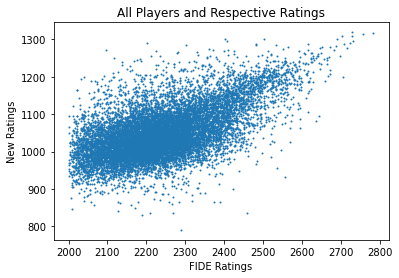

In [78]:
dd = init_ratings.merge(pd.DataFrame({"Rating": [G.nodes[node].rating for node in G.nodes], "Player": [node for node in G.nodes]}), left_on="Player", right_on="Player")
plt.scatter(dd.Rating_x, dd.Rating_y, s=1)
plt.xlabel("FIDE Ratings")
plt.ylabel("New Ratings")
plt.title("All Players and Respective Ratings")

In [65]:
# train_data.to_csv(data_dir + "processed_with_rating.csv")

In [97]:
train_data = pd.read_csv(data_dir + "processed_with_rating.csv")

### Training with new labels

In [96]:
all_data = train_data.iloc[
    ~(
        pd.isna(train_data.BlackRating).values | 
        pd.isna(train_data.WhiteRating).values | 
        (train_data.BlackRating.values == 0) | 
        (train_data.WhiteRating.values == 0)
    )
]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


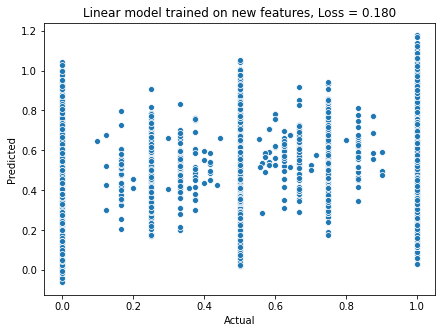

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   11.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.1s finished


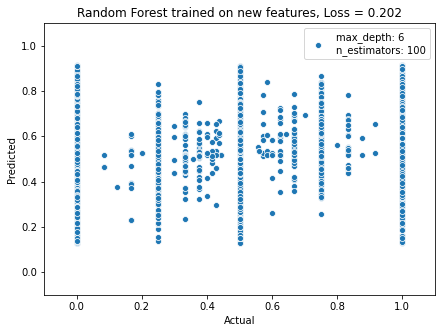

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


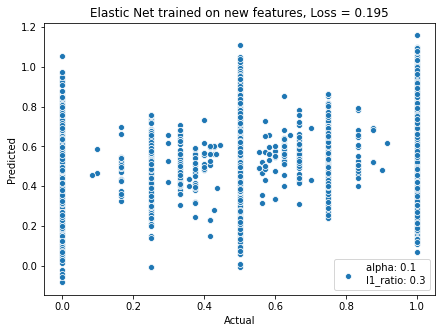

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    6.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.8s finished


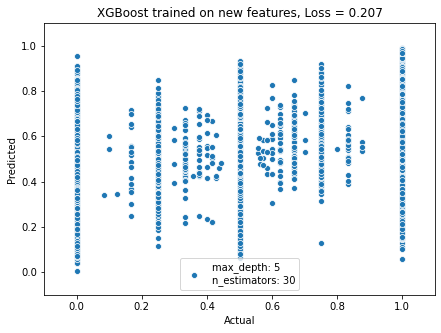

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


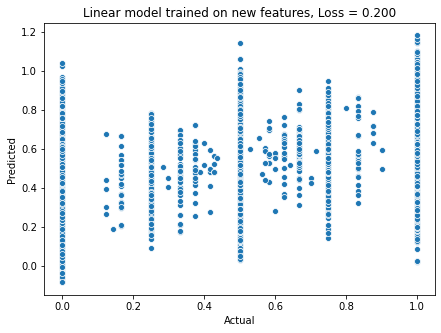

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   11.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.4s finished


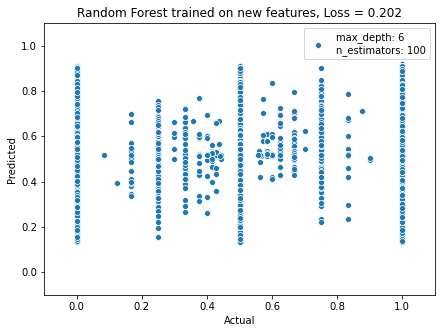

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


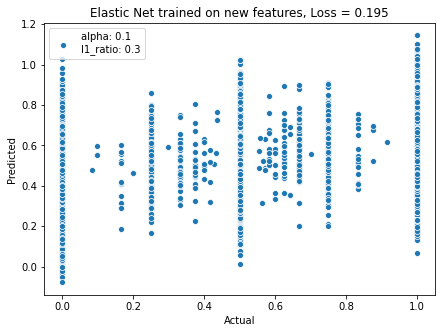

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    6.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    8.1s finished


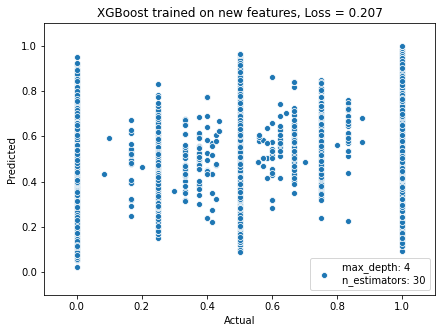

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


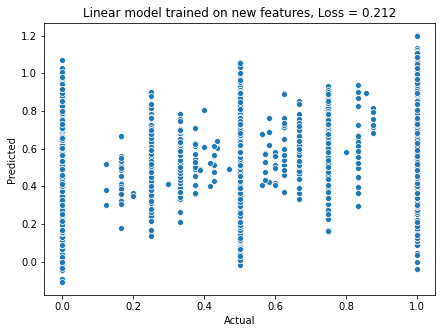

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   13.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   16.1s finished


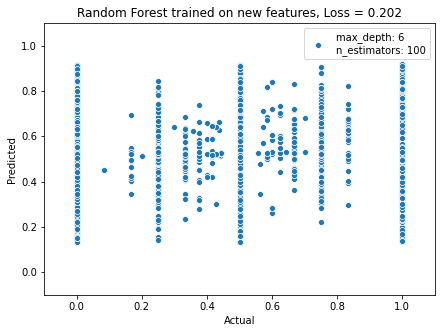

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


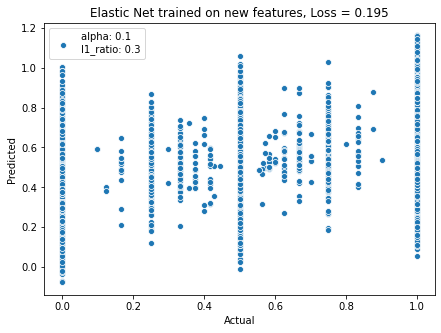

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.1s finished


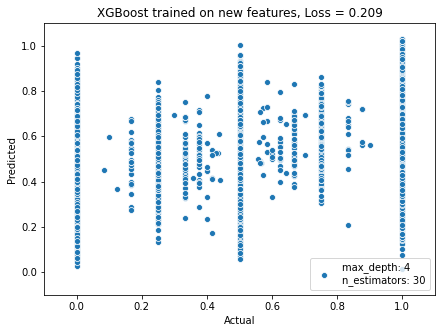

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


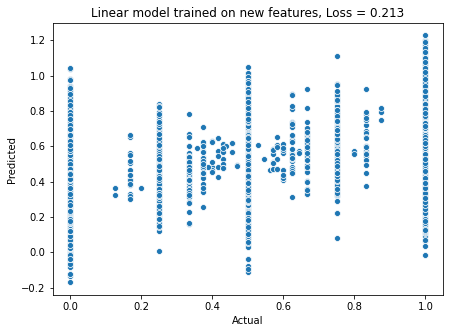

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   14.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   17.9s finished


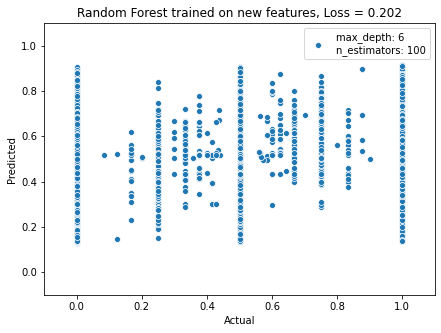

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


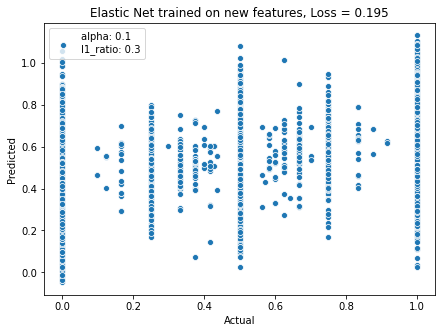

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.5s finished


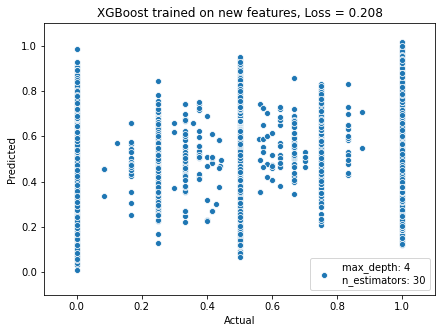

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


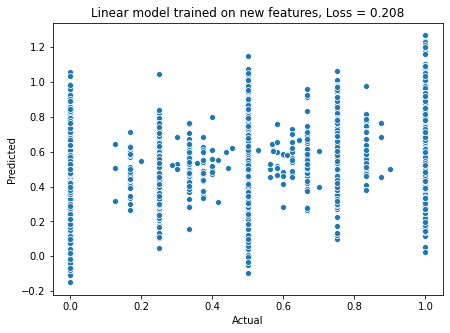

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   13.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   17.1s finished


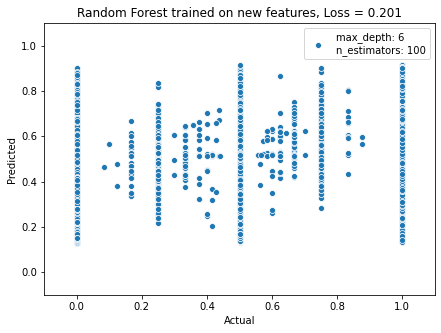

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


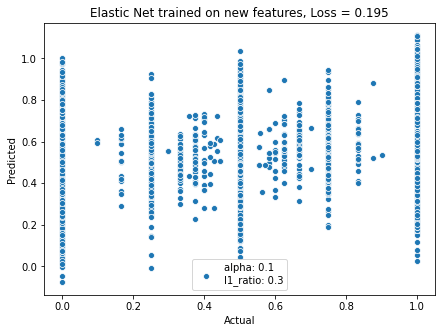

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    9.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.3s finished


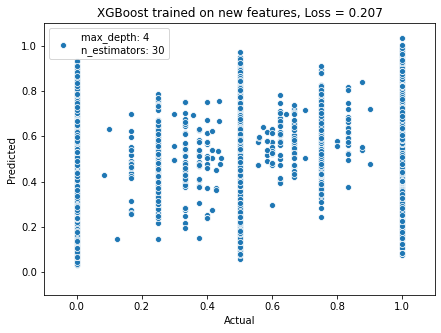

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


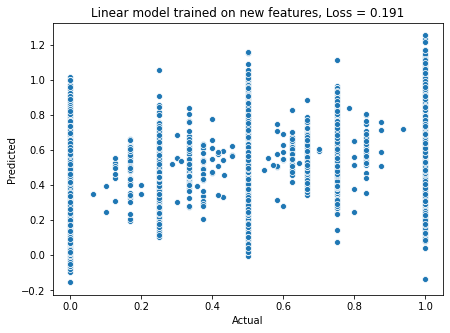

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   16.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   19.7s finished


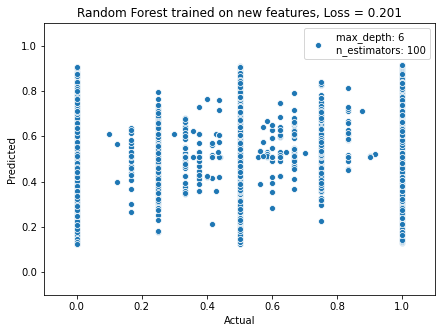

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


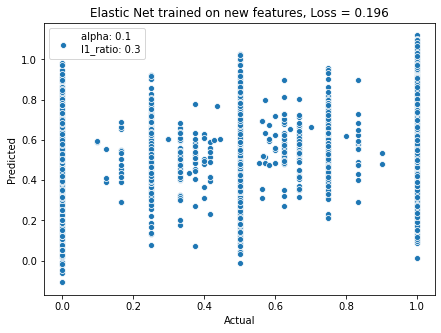

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   10.2s finished


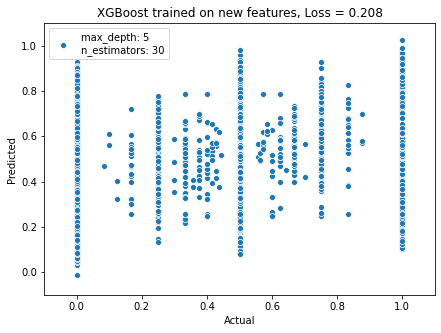

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


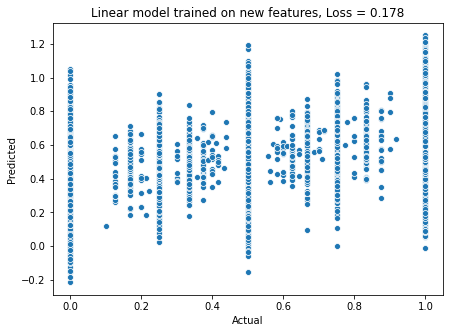

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   13.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   17.1s finished


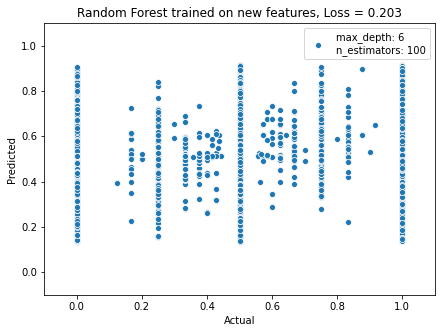

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished


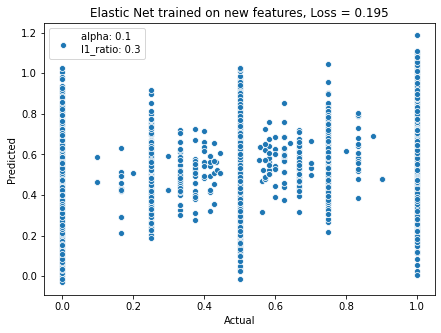

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.7s finished


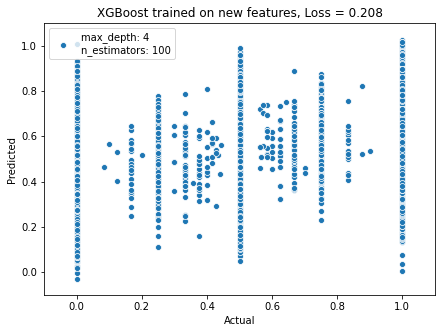

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


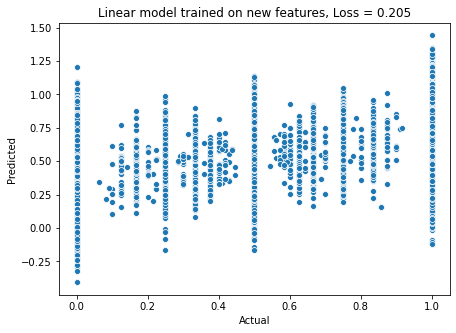

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   14.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   16.9s finished


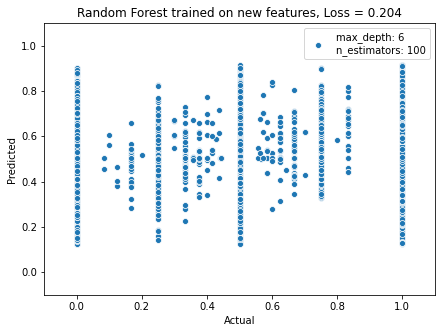

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.1s finished


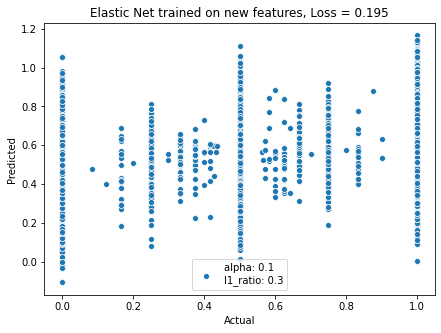

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    7.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.4s finished


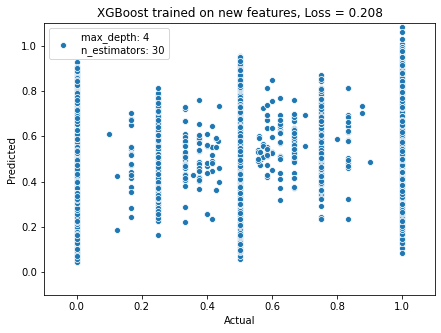

In [126]:
ls = window_split(train_data, min_len=4)

linear_losses = []
rf_losses = []
xgb_losses = []
elasticnet_losses = []

for n, (train_inds, test_inds) in tqdm(enumerate(ls)):
    
    # Linear Regression
    clf, test_X, train_y, test_y = get_loss(
        all_data.iloc[train_inds[0]: train_inds[1]], 
        "WhitePlayer", 
        "BlackPlayer", 
        feature_cols=["WhiteRating", "BlackRating", "WhitePlayerPrev", "BlackPlayerPrev"], 
        result_col="WhiteScore",
        model_func=LinearRegression,
        feature_dict={},
    )
    plt.figure(figsize=(7, 5))
    fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
    fig.set(xlabel="Actual", ylabel="Predicted")
    fig.set_title("Linear model trained on new features, Loss = {:.3f}".format(clf.best_score_))
    plt.savefig(fig_dir + "new_linear_iter_{}.png".format(n))
    plt.show()
    linear_losses.append(clf.best_score_ * test_X.shape[0])

    # Random Forest
    clf, test_X, train_y, test_y = get_loss(
        rated_games, 
        "WhitePlayer", 
        "BlackPlayer", 
        feature_cols=["WhiteRating", "BlackRating", "WhitePlayerPrev", "BlackPlayerPrev"], 
        result_col="WhiteScore",
        model_func=RandomForestRegressor,
        feature_dict={"max_depth": [4, 5, 6], "n_estimators": [30, 100]},
    )
    plt.figure(figsize=(7, 5))
    fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
    fig.set(xlabel="Actual", ylabel="Predicted")
    fig.set_title("Random Forest trained on new features, Loss = {:.3f}".format(clf.best_score_))
    plt.savefig(fig_dir + "new_randomforest_iter_{}.png".format(n))
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    rf_losses.append(clf.best_score_ * test_X.shape[0])
    
    # Elastic Net
    clf, test_X, train_y, test_y = get_loss(
        rated_games, 
        "WhitePlayer", 
        "BlackPlayer", 
        feature_cols=["WhiteRating", "BlackRating"], 
        result_col="WhiteScore", 
        model_func=ElasticNet,
        feature_dict={"l1_ratio": [0.3, 0.5, 0.7], "alpha": [0.1, 1, 10]}
    )
    plt.figure(figsize=(7, 5))
    fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
    fig.set(xlabel="Actual", ylabel="Predicted")
    fig.set_title("Elastic Net trained on new features, Loss = {:.3f}".format(clf.best_score_))
    plt.savefig(fig_dir + "new_elasticnet_iter_{}.png".format(n))
    plt.show()
    elasticnet_losses.append(clf.best_score_ * test_X.shape[0])
    
    # XGBoost
    clf, test_X, train_y, test_y = get_loss(
        rated_games, 
        "WhitePlayer", 
        "BlackPlayer", 
        feature_cols=["WhiteRating", "BlackRating", "WhitePlayerPrev", "BlackPlayerPrev"], 
        result_col="WhiteScore",
        model_func=XGBRegressor,
        feature_dict={"max_depth": [4, 5, 6], "n_estimators": [30, 100]},
    )
    plt.figure(figsize=(7, 5))
    fig = sns.scatterplot(x=test_y, y=clf.predict(test_X), label='\n'.join([str(key) + ": " + str(value) for key, value in clf.best_params_.items()]))
    fig.set(xlabel="Actual", ylabel="Predicted")
    fig.set_title("XGBoost trained on new features, Loss = {:.3f}".format(clf.best_score_))
    plt.savefig(fig_dir + "new_xgb_iter_{}.png".format(n))
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    xgb_losses.append(clf.best_score_ * test_X.shape[0])


In [470]:
for i, j in ls:
    print(i, j)

In [249]:
G = ScoreGraph(rated_games, 'WhiteScore', 'WhitePlayer', 'BlackPlayer')

In [228]:
G.gen_scores(n_rounds=100)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1.0 999.0 1001.0 [0.0]
-1.004975 1000.0099749999999 998.995025 [1.0]
1.0385384498079657 1002.8153065309886 1001.038538449808 [0.5, 0.0]
1.0451511178649695 1003.469960668632 1001.045151117865 [0.5, 0.0]
1.0623225111789998 1011.402179724621 1001.062322511179 [0.0]
1.083408429510414 1015.5982774725724 1001.0834084295104 [0.0]
1.1620674176919443 1015.0446743515025 1001.1620674176919 [0.0, 0.5]
2.9111175280687984 991.1633843431845 1002.9111175280688 [0.0, 0.0, 0.0]
3.8173131019423545 1050.670227027548 1003.8173131019423 [0.0, 0.0, 0.0]
-4.06893000802115 1000.6224296069637 995.9310699919788 [1.0, 1.0, 1.0, 1.0]
5.3097701226279 1002.530312291978 1009.7079622858128 [0.5, 0.5, 0.5, 0.5, 0.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0]
5.740619562582442 1026.0442183713042 1007.9006749931714 [0.0, 0.0, 0.0, 0.0, 0.0]
8.932968615331516 992.1158001944787 1011.3223651185115 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0]
9.147998786568508 1025.8658847880624 1028.8552318736192

  1%|▊                                                                                 | 1/100 [00:06<10:41,  6.48s/it]

0.8018102828386731 986.8085114596555 1028.0500754575983 [0.0]
-1.0444303780129984 987.8278784307153 994.625093277289 [1.0]
1.2469837320769888 1028.4931167727095 1006.2887110291647 [0.5, 0.0]
-1.270394395842054 1029.6610231812926 1081.1991135580195 [1.0]
1.2905464865043887 1034.7271538338161 979.1989495059471 [0.0]
-1.2972160413957137 1037.2701369145857 1094.1189131109368 [1.0]
-1.5780969901127275 980.077612078504 1092.540816120824 [1.0]
1.8955730477646398 957.4203705678431 1034.8399801457297 [0.0, 0.0, 0.0]
1.943701925006958 999.6367836614511 1009.1539950107692 [0.0, 0.0]
2.328265297834075 1100.544563854281 1072.3745646665418 [0.0, 0.0]
2.3374823975578973 1110.0083395027839 1076.4695215105314 [0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0]
2.4304117471857967 1109.7104769737741 1071.5301257495662 [0.0, 0.0]
3.7889223276472794 1118.0093016788574 1072.9923244909999 [0.0, 0.0, 0.0]
5.4111250649670755 1090.5307384510052 1084.9079859822564 [0.0, 0.0, 0.0, 0.0, 0.0]
5.722100994457145 1015.1704095672229 1

  2%|█▋                                                                                | 2/100 [00:13<10:40,  6.53s/it]

0.6880550762581942 979.0305497980914 1042.795644698969 [0.0]
-1.0994027450782806 980.100516541421 997.7822600669207 [1.0]
1.3325844006345267 1042.5478763496346 1011.954605087451 [0.5, 0.0]
-1.3721737756133405 1042.9690994080468 1114.659506979488 [1.0]
1.4158084990717106 1047.1934636417525 966.8633808255538 [0.0]
-1.6699788681453913 972.7397220842922 1103.3955379770798 [1.0]
1.7814286500363432 1027.0886904045565 937.9372593700843 [0.5, 0.5, 1.0, 0.5, 0.0, 1.0]
1.857831996945132 995.8521990579417 1013.7846633573188 [0.0, 0.0]
2.3303184655956146 1131.9137054849132 1103.542495856543 [0.0, 0.0]
2.3429926914164407 1136.7839777771724 1103.0987434052497 [0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0]
2.4114720730443424 1136.2345174739487 1099.910254315603 [0.0, 0.0]
3.520729105113512 1143.3299910207484 1115.6561755567413 [0.0, 0.0, 0.0]
-3.698671375564794 1017.7488000087674 1056.9295489619574 [1.0, 1.0, 1.0]
5.255282241275291 1112.6729215378962 1112.9721963694353 [0.0, 0.0, 0.0, 0.0, 0.0]
5.42563624175357

  3%|██▍                                                                               | 3/100 [00:19<10:42,  6.62s/it]

0.6233542737376775 973.6080607731258 1050.1839145730657 [0.0]
-1.1499580184514269 974.7336639846517 1002.4253516380342 [1.0]
1.3559771487009982 1049.6531269302463 1016.7673663575484 [0.5, 0.0]
-1.4277917311145278 1049.790233239336 1132.4929960000127 [1.0]
1.487878153850228 1053.6916249949754 959.0917505326304 [0.0]
-1.7194464902721478 969.023218776008 1109.4736238498933 [1.0]
-2.145934019293786 933.0648405615917 1033.637439832797 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
2.1782366852016715 1031.4592031475954 929.874453677943 [0.5, 0.5, 1.0, 0.5, 0.0, 1.0]
2.3278478459135092 1147.796326865095 1119.667237965571 [0.0, 0.0]
2.3468444307907266 1150.925265954487 1117.1376853649049 [0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0]
2.403832418303391 1150.4227783790582 1114.847201385326 [0.0, 0.0]
3.385161037307365 1157.1716154342012 1138.2645350216583 [0.0, 0.0, 0.0]
-3.6660004420842482 1032.5203714988825 1069.5884000869974 [1.0, 1.0, 1.0]
-3.703525412169158 1127.2278960748133 1076.6050256561134 [1.0, 1.0, 1.0, 1.0, 1

  4%|███▎                                                                              | 4/100 [00:26<10:33,  6.60s/it]

0.5818982198322646 969.6466257368872 1054.4307782100989 [0.0]
-1.1921392560520883 970.8240561864199 1006.8676288847333 [1.0]
1.3577767203832969 1053.7769990780282 1020.7148804804651 [0.5, 0.0]
-1.4645831119204662 1053.8417665696766 1143.8292227299287 [1.0]
1.534584833683901 1057.5920237338353 953.744226664423 [0.0]
-1.747917826159026 967.3792610543541 1113.4669906338413 [1.0]
-2.416671362964444 927.0697899454134 1036.1254926516326 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.320827828927528 1166.0788997553257 1151.332033484679 [0.0, 0.0, 0.0]
-3.6383378132632456 1042.8517571458067 1078.13093573683 [1.0, 1.0, 1.0]
-3.7923210181420197 1135.3397905529232 1087.4991824547064 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.20050675168157 1133.3813422380347 1135.762085674135 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.242931962463593 1227.3165991558935 1247.137392105706 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5]
5.686819889164934 1210.60

  5%|████                                                                              | 5/100 [00:33<10:25,  6.58s/it]

0.5528403126495942 966.6861777598916 1057.2237958552719 [0.0]
-1.2259616747635311 967.9089955843903 1010.6494071875694 [1.0]
1.3529751723259074 1056.5101029411821 1023.9185360532432 [0.5, 0.0]
-1.4908937232745143 1056.5905965235133 1151.7875537318673 [1.0]
1.5679744323401252 1060.2498589266843 949.7909213233396 [0.0]
-1.764717048889629 966.9559192704066 1116.369894950553 [1.0]
-2.5772890995800664 923.6048683380449 1037.693260124887 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2890494600140423 1172.4175126200164 1159.7256475391082 [0.0, 0.0, 0.0]
-3.61981645377062 1050.286892368032 1084.368356378532 [1.0, 1.0, 1.0]
-3.848199474575267 1141.2226056354361 1095.1328558387945 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.197486502771767 1139.391458073269 1141.8869709679416 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.416067894427386 1239.7302680887933 1260.4414744029912 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5]
5.428236321566954 1217.

  6%|████▉                                                                             | 6/100 [00:40<10:30,  6.71s/it]

0.5313570076871434 964.4556060114952 1059.2469184894408 [0.0]
-1.2525756698266595 965.7170700874894 1013.727052713168 [1.0]
1.3468000389739132 1058.5009919279207 1026.5145881084773 [0.5, 0.0]
-1.5106649733326265 1058.6338755475992 1157.745540267459 [1.0]
1.5935693485537115 1062.2283193392138 946.701588325579 [0.0]
-1.774422663835274 967.2597470310509 1118.595434470435 [1.0]
-2.678103661573546 921.5855855058604 1038.8328335684982 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.272006433968255 1177.1929757411197 1165.6032263445059 [0.0, 0.0, 0.0]
-3.2776870129841633 1062.7323220230546 1020.0612986462944 [1.0, 1.0, 1.0, 1.0]
-3.607258987600791 1055.9051365408752 1089.1745510723931 [1.0, 1.0, 1.0]
-3.8855560178694004 1145.7420491550984 1100.8228043816728 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.198799850830586 1144.0193944000712 1146.4650000685087 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.509344075320881 1247.918058638626 1269.1089710259907 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5,

  7%|█████▋                                                                            | 7/100 [00:47<10:40,  6.88s/it]

0.5150003748418647 962.7778705793277 1060.8077963606386 [0.0]
-1.2733398849994308 964.0718039358698 1016.193101165757 [1.0]
1.3409725822437282 1060.043187050358 1028.6278739904726 [0.5, 0.0]
-1.5260784895183201 1060.2434248975162 1162.4069658221435 [1.0]
1.6141489121383013 1063.7871058690544 944.1856212656706 [0.0]
-1.7796735929744654 967.9924937322915 1120.3678651412356 [1.0]
-2.7456906562665746 920.3732081671037 1039.7381820634564 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2618051144295794 1180.9327351554875 1170.0026710890413 [0.0, 0.0, 0.0]
-3.281548123154544 1066.8009899252486 1024.3152998366666 [1.0, 1.0, 1.0, 1.0]
-3.5986244886775385 1060.338142549907 1093.049192817721 [1.0, 1.0, 1.0]
-3.912289824249687 1149.3480364455183 1105.2664509386752 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.201789852981091 1147.729563028848 1150.0615486155666 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.56401364455094 1253.7506651062236 1275.2227352782 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0

  8%|██████▌                                                                           | 8/100 [00:54<10:28,  6.83s/it]

0.5023579879916309 961.5304121951984 1062.0635305728556 [0.0]
-1.289488054536668 962.8514465809955 1018.1700813792556 [1.0]
1.3359509630931075 1061.2876850147381 1030.3644906316138 [0.5, 0.0]
-1.538454988621146 1061.5603362105983 1166.174423957585 [1.0]
1.631240477044599 1065.0622663536758 942.0766518988453 [0.0]
-1.7820709314782608 968.9688660063023 1121.8189104389978 [1.0]
-2.7937966878255716 919.6211631781028 1040.4934593966375 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.255225395961264 1183.9581432841428 1173.453567678648 [0.0, 0.0, 0.0]
-3.285670045502775 1070.1374606704749 1027.8496228546082 [1.0, 1.0, 1.0, 1.0]
-3.592121173200984 1063.9559794761544 1096.2464820098182 [1.0, 1.0, 1.0]
-3.93243579542262 1152.3069903691205 1108.8566452923626 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.205700169968435 1150.7820944691136 1152.965488010313 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.598852874234961 1258.1569140581369 1279.808157411345 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.

  9%|███████▍                                                                          | 9/100 [01:00<10:12,  6.73s/it]

0.4925189201726346 960.6220116566292 1063.1032654624476 [0.0]
-1.3020417952854542 961.9655990529485 1019.7698745194683 [1.0]
1.3317472029619262 1062.32090983037 1031.8096839401012 [0.5, 0.0]
-1.5486917004150211 1062.666347767157 1169.3073044493312 [1.0]
1.6457909681800873 1066.1333589252656 940.2667472256084 [0.0]
-1.7825744249116509 970.0710747203493 1123.0208108528561 [1.0]
-2.8303260330464832 919.1270482376067 1041.1439306063965 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2511520994442162 1186.4774056266638 1176.236236529271 [0.0, 0.0, 0.0]
-3.2897168113835917 1072.9298175272045 1030.8362244736168 [1.0, 1.0, 1.0, 1.0]
-3.586821775430691 1066.9846485488736 1098.9324566933915 [1.0, 1.0, 1.0]
-3.9478043983877495 1154.8013068205319 1111.8325113033482 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.210146039728755 1153.3509111453038 1155.365361635611 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.622744139487148 1261.6319261639678 1283.4060388813302 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0

 10%|████████                                                                         | 10/100 [01:07<09:59,  6.66s/it]

0.48485275647061316 959.9831674996879 1063.9823217185065 [0.0]
-1.311808073479941 961.3454985139958 1021.0834970630242 [1.0]
1.3282442006514474 1063.1967304951554 1033.0287988313135 [0.5, 0.0]
-1.5573368406847998 1063.6128901430836 1171.9655845986738 [1.0]
1.6583751063708883 1067.0504920152473 938.6922209538113 [0.0]
-1.7819768252871335 971.2239964841634 1124.0554078910159 [1.0]
-2.8589567331921897 918.8032060860146 1041.7171837260366 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2486716178067545 1188.6185824477336 1178.5378178295637 [0.0, 0.0, 0.0]
-3.2936147376596 1075.303682741501 1033.3971901491616 [1.0, 1.0, 1.0, 1.0]
-3.582307490795555 1069.5679438852846 1101.223828290064 [1.0, 1.0, 1.0]
-3.959664674597081 1156.9460000132858 1114.3488264839946 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.214881794729599 1155.5492773012888 1157.383769101564 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.640101258305397 1264.4608087781323 1286.3241866779888 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5

 11%|████████▉                                                                        | 11/100 [01:13<09:48,  6.61s/it]

0.4788985013810674 959.5597930237674 1064.737889750316 [0.0]
-1.319413446496891 960.9376878495203 1022.1815502559047 [1.0]
1.3253051228430628 1063.951338278429 1034.0714362398087 [0.5, 0.0]
-1.5646815927469846 1064.4349852877554 1174.241940651658 [1.0]
1.6693718235432515 1067.8475912825659 937.3119702210021 [0.0]
-1.7806583420629745 972.3795641528027 1124.9499158812716 [1.0]
-2.8819624945084947 918.597505991718 1042.2323308196508 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2471409079326916 1190.4608048501013 1180.4790261371204 [0.0, 0.0, 0.0]
-3.297357951176714 1077.3465154925923 1035.6196971490745 [1.0, 1.0, 1.0, 1.0]
-3.5785626623424727 1071.8027954929273 1103.2165143244074 [1.0, 1.0, 1.0]
-3.9693751361804193 1158.802825204924 1116.5099128052439 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.2194010692460555 1157.4505304080628 1159.1132897767127 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.653287766336655 1266.8186468916585 1288.7498411185327 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0

 12%|█████████▋                                                                       | 12/100 [01:20<09:39,  6.59s/it]

0.47430710718292063 959.3092795821973 1065.396472359979 [0.0]
-1.3253330313724092 960.7000761886666 1023.1160164004035 [1.0]
-1.570995483285749 1065.1580142682658 1176.215119958844 [1.0]
1.6791151597757032 1068.549212973318 936.0844113377286 [0.0]
-1.7790698207054396 973.5079028279432 1125.7637273276202 [1.0]
-2.9010584992407633 918.4711383070344 1042.7043046165784 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.246203364712064 1192.0631247969588 1182.141973878912 [0.0, 0.0, 0.0]
-3.3009381956605104 1079.1231502646563 1037.5681836563606 [1.0, 1.0, 1.0, 1.0]
-3.5752035917630676 1073.7586051571323 1104.955104091144 [1.0, 1.0, 1.0]
-3.977556907123623 1160.427184035802 1118.390633792342 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.223643225529014 1159.1120105795405 1160.613568009438 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.663620171280734 1268.8200260175338 1290.8043583269778 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5]
6.34515157658

 13%|██████████▌                                                                      | 13/100 [01:26<09:31,  6.57s/it]

0.47080708842297725 959.1971708295875 1065.977367321838 [0.0]
-1.3299317580646812 960.5986426664665 1023.9251307632733 [1.0]
-1.5764761362771413 1065.800692561153 1177.9429675440272 [1.0]
1.6877939681769782 1069.1733357553474 934.9901300563056 [0.0]
-1.7774116813701983 974.5911015099631 1126.5186144212623 [1.0]
-2.9179005551056414 918.4047908576713 1043.165674917648 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.2456370108035557 1193.4692102249671 1183.5846835263374 [0.0, 0.0, 0.0]
-3.3043480997471124 1080.6821641958036 1039.290872983665 [1.0, 1.0, 1.0, 1.0]
-3.572139159390813 1075.486201660992 1106.4845339682645 [1.0, 1.0, 1.0]
-3.984440029478928 1161.865827887633 1120.044948811306 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.227697396150808 1160.5794352445203 1161.9269341907898 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.671918659004199 1270.5435353316504 1292.5705455779578 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5]
6.373402371

 14%|███████████▎                                                                     | 14/100 [01:33<09:30,  6.63s/it]

0.4681622179082092 959.1903069972311 1066.4941878514057 [0.0]
-1.333515175240055 960.6006412871571 1024.636645984688 [1.0]
-1.581275232991063 1066.3764028934115 1179.4688990256418 [1.0]
1.6955942786972902 1069.7329191204765 934.0052519384132 [0.0]
-1.775661399551696 975.6189699247659 1127.1999270360018 [1.0]
-2.932639627836728 918.3848404952948 1043.607548834179 [0.5, 0.5, 0.0, 0.5, 1.0, 0.0]
3.245286420318505 1194.71178145133 1184.8499262707332 [0.0, 0.0, 0.0]
-3.3075709151394133 1082.060755466608 1040.8241593932999 [1.0, 1.0, 1.0, 1.0]
-3.5693148122650515 1077.0240133202594 1107.8397045133995 [1.0, 1.0, 1.0]
-3.990536264815257 1163.143016706255 1121.5131530037995 [1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
5.231221513077912 1161.8834048549502 1163.0969873579897 [0.0, 0.0, 0.0, 0.0, 0.0]
-5.678713416393315 1272.0453914678171 1294.107346180697 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5]
6.39760846223696

 14%|███████████▎                                                                     | 14/100 [01:35<09:45,  6.81s/it]


KeyboardInterrupt: 

In [230]:
np.mean([G.nodes[node].rating for node in G.nodes])

1000.0

In [232]:
sorted([(node, G.nodes[node].rating) for node in G.nodes], key=lambda x:-x[1])

[(9399.0, 1291.9494443130507),
 (41314.0, 1270.1226381071162),
 (2115.0, 1266.2574065048036),
 (21308.0, 1262.9434622659098),
 (16709.0, 1249.9105691159384),
 (37711.0, 1245.819649754603),
 (28823.0, 1242.221204982856),
 (52525.0, 1241.8251932349026),
 (7772.0, 1241.1125625158763),
 (6048.0, 1239.7669932167803),
 (9394.0, 1239.5904693679677),
 (2381.0, 1237.743900210144),
 (6961.0, 1236.8817136867924),
 (16901.0, 1233.4614229722222),
 (23254.0, 1230.42795052691),
 (9271.0, 1229.1170759244278),
 (31910.0, 1226.2669433912838),
 (27271.0, 1220.972827629228),
 (45705.0, 1220.9483426746795),
 (25513.0, 1219.725883620384),
 (50051.0, 1219.0728183383965),
 (35160.0, 1218.6185114477205),
 (45165.0, 1217.8736140232902),
 (29049.0, 1214.7699344845917),
 (38020.0, 1214.4098122143632),
 (35387.0, 1213.0494008551825),
 (23746.0, 1212.9954667262405),
 (51004.0, 1212.3769831919517),
 (14239.0, 1211.810384132786),
 (36248.0, 1211.4180436857685),
 (49612.0, 1211.281303002828),
 (20988.0, 1211.170469257

In [235]:
rating_dict = {player: rating for player, rating in dd[["Player", "Rating_y"]].values}

In [244]:
rated_games.loc[:, "WhiteRating"] = [rating_dict[i] for i in rated_games.WhitePlayer]
rated_games.loc[:, "BlackRating"] = [rating_dict[i] for i in rated_games.BlackPlayer]

In [84]:
train_data.iloc[1000000:1100000]

,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,YearID,WhiteRating,BlackRating
PTID,,,,,,,,,
1000001,114,577,25003,0.5,21,29,9,1009.125407,954.448101
1000002,114,577,36191,0.0,21,17,9,1009.125407,927.689664
1000003,114,577,42631,0.5,21,22,9,1009.125407,914.079250
1000004,114,587,2003,0.5,46,34,9,1058.120626,1042.436412
1000005,114,587,15883,0.5,46,8,9,1058.120626,1028.130621
...,...,...,...,...,...,...,...,...,...
1099996,116,6677,5890,0.0,10,62,9,966.586170,1046.530617
1099997,116,6677,19468,0.5,10,23,9,966.586170,953.335648
1099998,116,6677,24078,0.5,10,51,9,966.586170,958.957474


In [89]:
pd.isna(train_data.BlackRating)

PTID
1          False
2          False
3          False
4          False
5          False
           ...  
1840120    False
1840121    False
1840122    False
1840123    False
1840124     True
Name: BlackRating, Length: 1840124, dtype: bool

,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,YearID,WhiteRating,BlackRating
PTID,,,,,,,,,
54333,13,33,18263,0.0,3,24,1,976.472746,1041.457614
54334,13,42,11964,1.0,1,7,1,1001.563920,966.372249
54335,13,42,13831,0.0,1,105,1,1001.563920,1089.803587
54336,13,42,32447,1.0,1,8,1,1001.563920,950.795108
54337,13,42,43438,0.0,1,1,1,1001.563920,991.887993
...,...,...,...,...,...,...,...,...,...
1840119,132,54200,7596,0.0,39,77,10,979.768962,1035.962739
1840120,132,54200,47563,0.0,39,16,10,979.768962,926.188182
1840121,132,54201,51735,1.0,17,62,10,1014.005994,995.670881


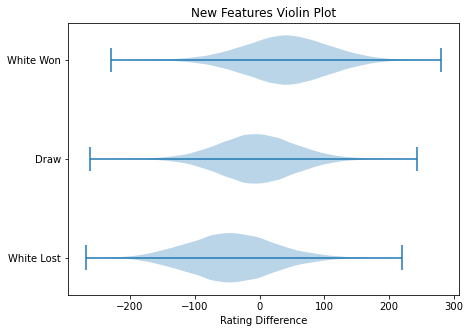

In [127]:
plotacc(all_data.iloc[200000:300000], title="New Features Violin Plot", save_as="new_violin.png")

In [26]:
rated_games

,PTID,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,WhiteRating,BlackRating
0,1,1,47,8911,0.0,0,0,2099,2432
1,2,1,47,46743,0.5,0,0,2099,2251
2,3,1,70,40287,0.5,0,0,2017,2317
3,4,1,90,8188,1.0,0,0,2282,2145
4,5,1,90,31200,0.0,0,0,2282,2136
...,...,...,...,...,...,...,...,...,...
624143,624144,96,54198,18669,0.5,13,136,2356,2350
624144,624145,96,54198,23069,0.5,13,9,2356,2408
624145,624146,96,54198,33612,0.5,13,5,2356,2308
624146,624147,96,54198,37721,0.5,13,65,2356,2203


In [12]:
train_1

,PTID,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev
0,1,1,47,8911,0.0,0,0
1,2,1,47,46743,0.5,0,0
2,3,1,70,40287,0.5,0,0
3,4,1,90,8188,1.0,0,0
4,5,1,90,31200,0.0,0,0
...,...,...,...,...,...,...,...
624143,624144,96,54198,18669,0.5,13,136
624144,624145,96,54198,23069,0.5,13,9
624145,624146,96,54198,33612,0.5,13,5
624146,624147,96,54198,37721,0.5,13,65


In [38]:
roll_df = train_1.groupby(['WhitePlayer', 'MonthID'])['PTID'].count().unstack(level=1).fillna(0).rolling(36, axis=1, min_periods=0).sum()
roll_df = pd.concat([pd.DataFrame([0.0] * roll_df.shape[0], index=roll_df.index), roll_df], axis=1)

In [23]:
roll_df.loc[47, :]

MonthID
1     2.0
2     2.0
3     2.0
4     2.0
5     2.0
     ... 
92    1.0
93    1.0
94    1.0
95    1.0
96    1.0
Name: 47, Length: 96, dtype: float64

In [43]:
def preprocess(df, timearray=[3, 12, 36]):
    
    num_games = df.groupby(['WhitePlayer', 'MonthID']).count()
    
    for months in timearray:
        
        roll_df = df.groupby(['WhitePlayer', 'MonthID'])['PTID'].count().unstack(level=1).fillna(0).rolling(months, axis=1, min_periods=1).sum() + \
                  df.groupby(['BlackPlayer', 'MonthID'])['PTID'].count().unstack(level=1).fillna(0).rolling(months, axis=1, min_periods=1).sum()
        
        roll_df = pd.concat([pd.DataFrame([0.0] * roll_df.shape[0], index=roll_df.index), roll_df], axis=1)
        
        df["WhitePrev{}m".format(months)] = [roll_df.loc[player, month - 1] for player, month in df[['WhitePlayer', 'MonthID']].values]
        df["BlackPrev{}m".format(months)] = [roll_df.loc[player, month - 1] for player, month in df[['BlackPlayer', 'MonthID']].values]
        
        roll_df = df.groupby(['WhitePlayer', 'MonthID'])['WhiteScore'].sum().unstack(level=1).fillna(0).rolling(months, axis=1, min_periods=1).sum()
        
        df["WhiteWinPrev{}m".format(months)] = [roll_df.loc[player, month - 1] for player, month in df[['WhitePlayer', 'MonthID']].values]
        df["BlackWinPrev{}m".format(months)] = [roll_df.loc[player, month - 1] for player, month in df[['BlackPlayer', 'MonthID']].values]
        
        df.groupby(['BlackPlayer', 'MonthID'])['WhiteScore'].sum().unstack(level=1).fillna(0).rolling(months, axis=1, min_periods=1).sum()
#     df['WhitePlayerPrev12m'] = 
#     df['WhitePlayerPrev3m'] = 

In [44]:
preprocess(train_1)

In [45]:
train_1

,PTID,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,WhitePlayerPrev3m,WhitePlayerPrev12m,WhitePlayerPrev36m,BlackPlayerPrev3m,BlackPlayerPrev12m,BlackPlayerPrev36m
0,1,1,47,8911,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,47,46743,0.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,70,40287,0.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,90,8188,1.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,90,31200,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624143,624144,96,54198,18669,0.5,13,136,0.0,4.0,34.0,2.0,54.0,215.0
624144,624145,96,54198,23069,0.5,13,9,0.0,4.0,34.0,1.0,9.0,21.0
624145,624146,96,54198,33612,0.5,13,5,0.0,4.0,34.0,0.0,5.0,26.0
624146,624147,96,54198,37721,0.5,13,65,0.0,4.0,34.0,0.0,51.0,83.0


{'bodies': [<matplotlib.collections.PolyCollection at 0x28cb04ac240>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x28cb04d2e80>,
 'cmins': <matplotlib.collections.LineCollection at 0x28cb175e2e8>,
 'cbars': <matplotlib.collections.LineCollection at 0x28cb175e518>}

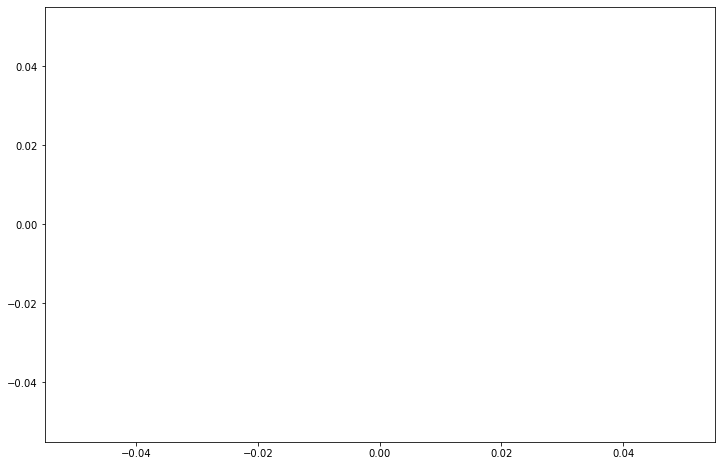

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
sample_games = rated_games.iloc[:1000, :]
diff_df = pd.DataFrame({
    "White Won": sample_games[sample_games.WhiteScore == 1].WhiteRating - sample_games[sample_games.WhiteScore == 1].BlackRating, 
    "Draw": sample_games[sample_games.WhiteScore == 0.5].WhiteRating - sample_games[sample_games.WhiteScore == 0.5].BlackRating, 
    "White Lost": sample_games[sample_games.WhiteScore == 0].WhiteRating - sample_games[sample_games.WhiteScore == 0].BlackRating, 
})
ax.violinplot(diff_df.iloc[:100, :], vert=False)
# plt.colorbar()
# plt.xlabel("Score Difference")
# plt.ylabel("Score Mean")
# plt.legend(loc="upper left")
# plt.title("Game results and FIDE score difference")
# plt.savefig(fig_dir + "FIDE Results.png")

In [ ]:
fig = plt.figure(figsize=(12, 8))
sample_games = rated_games.iloc[:1000, :]
plt.scatter(
    sample_games.Rating_White - sample_games.Rating_Black, 
    0.5 * (sample_games.Rating_White + sample_games.Rating_Black), 
    s=10, c=sample_games.WhiteScore, label="Score of white player", cmap="brg"
)
plt.colorbar()
plt.xlabel("Score Difference")
plt.ylabel("Score Mean")
plt.legend(loc="upper left")
plt.title("Game results and FIDE score difference")
plt.savefig(fig_dir + "FIDE Results.png")

In [5]:
train_1

,PTID,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev
0,1,1,47,8911,0.0,0,0
1,2,1,47,46743,0.5,0,0
2,3,1,70,40287,0.5,0,0
3,4,1,90,8188,1.0,0,0
4,5,1,90,31200,0.0,0,0
...,...,...,...,...,...,...,...
624143,624144,96,54198,18669,0.5,13,136
624144,624145,96,54198,23069,0.5,13,9
624145,624146,96,54198,33612,0.5,13,5
624146,624147,96,54198,37721,0.5,13,65


### Metrics

In [15]:
init_ratings["Rating"].quantile(0.95)

2461.0

In [17]:
init_ratings

,Player,Rating,KFactor,NumGames
0,3,2116,15,30
1,10,2421,10,30
2,16,2252,15,30
3,19,2352,25,10
4,22,2263,15,30
...,...,...,...,...
14113,54194,2185,15,30
14114,54195,2451,10,30
14115,54198,2356,10,30
14116,54202,2026,15,30


In [263]:
from sklearn.model_selection import GridSearchCV

In [272]:
rated_games.head(2)

,PTID,MonthID,WhitePlayer,BlackPlayer,WhiteScore,WhitePlayerPrev,BlackPlayerPrev,WhiteRating,BlackRating
0,1,1,47,8911,0.0,0,0,958.088245,1068.858159
1,2,1,47,46743,0.5,0,0,958.088245,976.231115


In [273]:
LinearRegression()

LinearRegression()

In [299]:
from sklearn.ensemble import RandomForestRegressor